In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

The dataset https://data.mendeley.com/datasets/vryvyfz2tj/1 (energy consumption and weather) discription given by the provider icludes 2 key notes:

1) energy consumption measurements of 172 different buildings, that are part of a local cooperative, i.e., they are geographically close to each other

2) The weather data was taken from the nearest weather station to Loureiro, which is in Aveiro, Portugal

A quick note: the weather dataset includes TOTAL GLOBAL RADIATION which is probably refering to "the sum of direct solar radiation from the sun and diffuse radiation scattered by the atmosphere or reflected by clouds, measured on a horizontal surface", so not radioactivity.

This analysis is zero'th step before we start training our model on this data. The goal of this analysis is to:

1) Understand something about the structure and quality of the data to check if there are missing values, how many of them and how are missing values organized in time. Investigate outliers

2) Feature engineering. We'll study data correlation to see if there are informative features we can use later for training, or if there are any redundant columns that would only add noise! Also if we want to perform clustering for fuether analysis and model saparation, what features are the most useful?

3) We also aim to answer the question: "How to deal with NaN values? What preprocessing is helpgul?"

#Basic EDA, check for NanNs, Duplicates etc, Quick Data Analysis.

Load our data frames, we have two: weather data and energy consumption.

Also check if those datasets align with each other, see if there are missing values.

In [33]:
energy_file_name = "loureiro_energy.csv"
weather_file_name = "weather_aveiro_final.csv"

weather_df = pd.read_csv(weather_file_name).set_index("Time")
weather_df.index = pd.to_datetime(weather_df.index)
energy_df = pd.read_csv(energy_file_name)
energy_df["Time"] = pd.to_datetime(energy_df["Time"])
energy_df

print(f"1) Weather dataset and energy dataset have the same number of rows len(weather_df)==len(energy_df) is {len(weather_df)==len(energy_df)}.\n2) All the dates are the same (weather_df.index==energy_df['Time']).all() is {(weather_df.index==energy_df["Time"]).all()}")
print(f"3) The energy dataset has {energy_df.isna().sum().sum()} missing values")
print(f"4) The weather dataset has {weather_df.isna().sum().sum()} missing values: \n\n")
print(weather_df[weather_df.isna().any(axis=1)])

1) Weather dataset and energy dataset have the same number of rows len(weather_df)==len(energy_df) is True.
2) All the dates are the same (weather_df.index==energy_df['Time']).all() is True
3) The energy dataset has 2014280 missing values
4) The weather dataset has 22 missing values: 


                     Avg_Temp  Avg_Rel_Humidity  Avg_Wind_Direction  \
Time                                                                  
2022-08-12 09:00:00       NaN               NaN               334.0   
2022-08-16 23:15:00       NaN               NaN                 8.5   
2022-10-12 10:00:00       NaN               NaN               274.0   
2022-10-12 10:15:00       NaN               NaN               301.0   
2022-11-09 07:30:00       NaN               NaN               137.0   
2023-05-26 09:15:00       NaN               NaN               107.0   

                     Avg_Wind_Speed  Max_Inst_Wind_Speed  Inst_Temp  \
Time                                                                  
2

In [53]:
energy_df.describe()

,Time,Energy_Meter_1,Energy_Meter_2,Energy_Meter_3,Energy_Meter_4,Energy_Meter_5,Energy_Meter_6,Energy_Meter_7,Energy_Meter_8,Energy_Meter_9,...,Energy_Meter_163,Energy_Meter_164,Energy_Meter_165,Energy_Meter_166,Energy_Meter_167,Energy_Meter_168,Energy_Meter_169,Energy_Meter_170,Energy_Meter_171,Energy_Meter_172
count,46608,41822.000000,41748.000000,31617.000000,40510.000000,39516.000000,33408.000000,9938.000000,41731.000000,41713.000000,...,40200.000000,41774.00000,39072.000000,28118.000000,16196.000000,33939.000000,23845.000000,29537.000000,27170.000000,40864.000000
mean,2023-01-03 05:52:30,0.092643,0.062613,0.116356,0.045887,0.002955,0.069740,0.024806,0.121322,0.092286,...,0.054436,0.00387,0.006162,0.087815,0.025371,0.540594,0.157338,0.273103,0.153591,0.086442
min,2022-05-05 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.004000,0.000000,0.017000,0.000000,0.000000,0.000000
25%,2022-09-03 20:56:15,0.038000,0.028000,0.044000,0.013000,0.000000,0.000000,0.007000,0.027000,0.051000,...,0.007000,0.00300,0.000000,0.006000,0.019000,0.312000,0.081000,0.142000,0.056000,0.029000
50%,2023-01-03 05:52:30,0.063000,0.046000,0.079000,0.032000,0.000000,0.000000,0.014000,0.095000,0.072000,...,0.008000,0.00400,0.000000,0.007000,0.022000,0.480000,0.114000,0.164000,0.095000,0.043000
75%,2023-05-04 14:48:45,0.103000,0.073000,0.105000,0.045000,0.000000,0.000000,0.021000,0.155000,0.098000,...,0.070250,0.00400,0.000000,0.013000,0.024000,0.735000,0.175000,0.371000,0.144000,0.067000
max,2023-09-02 23:45:00,1.513000,0.962000,1.593000,1.738000,1.032000,1.594000,0.979000,1.412000,0.772000,...,0.509000,0.05000,0.669000,1.530000,0.600000,1.900000,0.995000,2.136000,1.803000,1.609000
std,NaN,0.104881,0.065718,0.143975,0.102041,0.014699,0.286786,0.060112,0.140283,0.087209,...,0.076120,0.00159,0.023565,0.195815,0.023271,0.287114,0.124936,0.199749,0.176724,0.140246


In the table above we see that there is a lot of missing data! Lets take a look at a portion of missing values per column

From correlation data on weather we don't see anything unexpected, like positive correlation between max_wind_speed and average_wind_speed, inst_tempreture and average_temreture etc. What is a bit more interesting is the strong negative correlation between radiation level and humidity, which can be understood as more humid air absorbs more solar radiation?

Now check the data types!

In [54]:
energy_df.dtypes

,0
Time,datetime64[ns]
Energy_Meter_1,float64
Energy_Meter_2,float64
Energy_Meter_3,float64
Energy_Meter_4,float64
...,...
Energy_Meter_168,float64
Energy_Meter_169,float64
Energy_Meter_170,float64
Energy_Meter_171,float64


The dataset description claims that the measurements are taken each 15 mins. We should verify this by directly comparing to pd.date_range and checking if the number of dates matches

In [55]:
(pd.date_range(start = energy_df["Time"].iloc[0], end =  energy_df["Time"].iloc[-1], freq="15min") == energy_df["Time"]).sum()

np.int64(46608)

Perfect! And check for duplicates

In [56]:
print(f"Teh dataset contains {energy_df["Time"].duplicated().sum()} time duplicates")

Teh dataset contains 0 time duplicates


<Axes: >

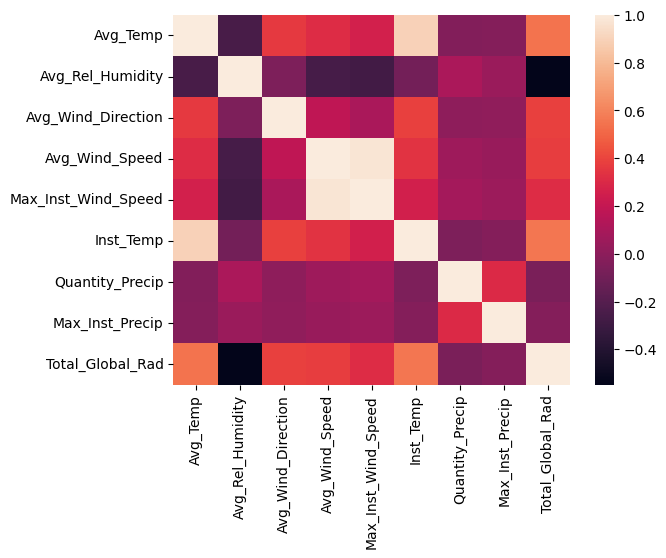

In [3]:
sns.heatmap(weather_df.corr())

Now we want to visualize our weather data. As to be expected, tempreture measurements get lower during winter times, as well as radiation. Precipitation volume also gets higher during fall.

It is questinable how useful wind direction and speed is. Also our analysis suggests that precipitation measurements are weak predictors as they don't show much correlation with any other measurements. Maybe we can discard it later, but we need to be careful as ther still might be some laged or highly nonlinear relationship.

Also average and instant measurements are highly correlated, so we might as well consider using only one of those, one that is less noisy, so averages.

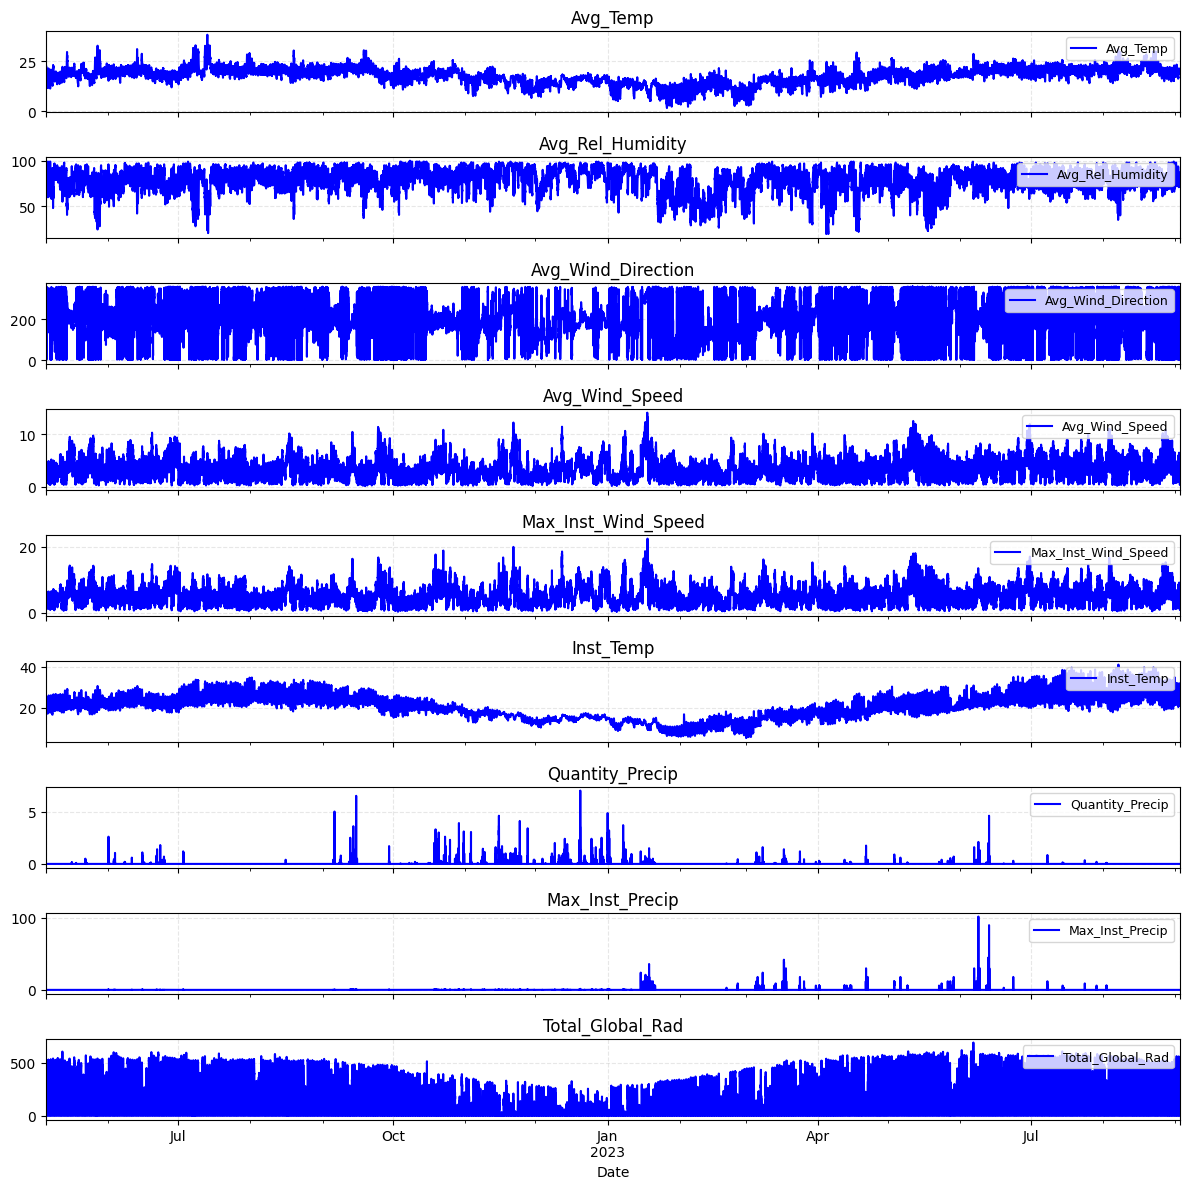

In [6]:
wc = weather_df.columns

fig, axes = plt.subplots(len(wc), 1, figsize=(12, 12), sharex=True)

for i, name in enumerate(wc):
    ax = axes[i]
    series = weather_df[name]

    series.plot(ax=ax, color='blue', legend=True, label=name)

    ax.set_title(name)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()

Let's give percipitation data a second chance. Maybe it's lag-correlated with humidity? We can test this with the help of CCF (cross-correlation function) that measures correlation between one series and lags of another. It is also recomended to use FFT for long time series.

The result below doesn't suggest any strong relation...

It is also bery possible that this lack of correlation is due to the fact that precipitations are zero most of the time, but might still be informative when present!

In [43]:
from statsmodels.graphics.tsaplots import plot_ccf

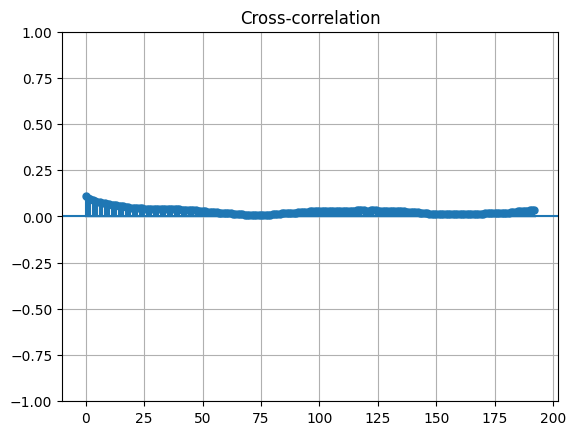

In [48]:
plot_ccf(weather_df['Quantity_Precip'].interpolate(), weather_df['Avg_Rel_Humidity'].interpolate(), fft = True, lags = 192)
plt.grid()
plt.show()


Let's check if the weather data actually makes sense, consider a more close up view at one day.

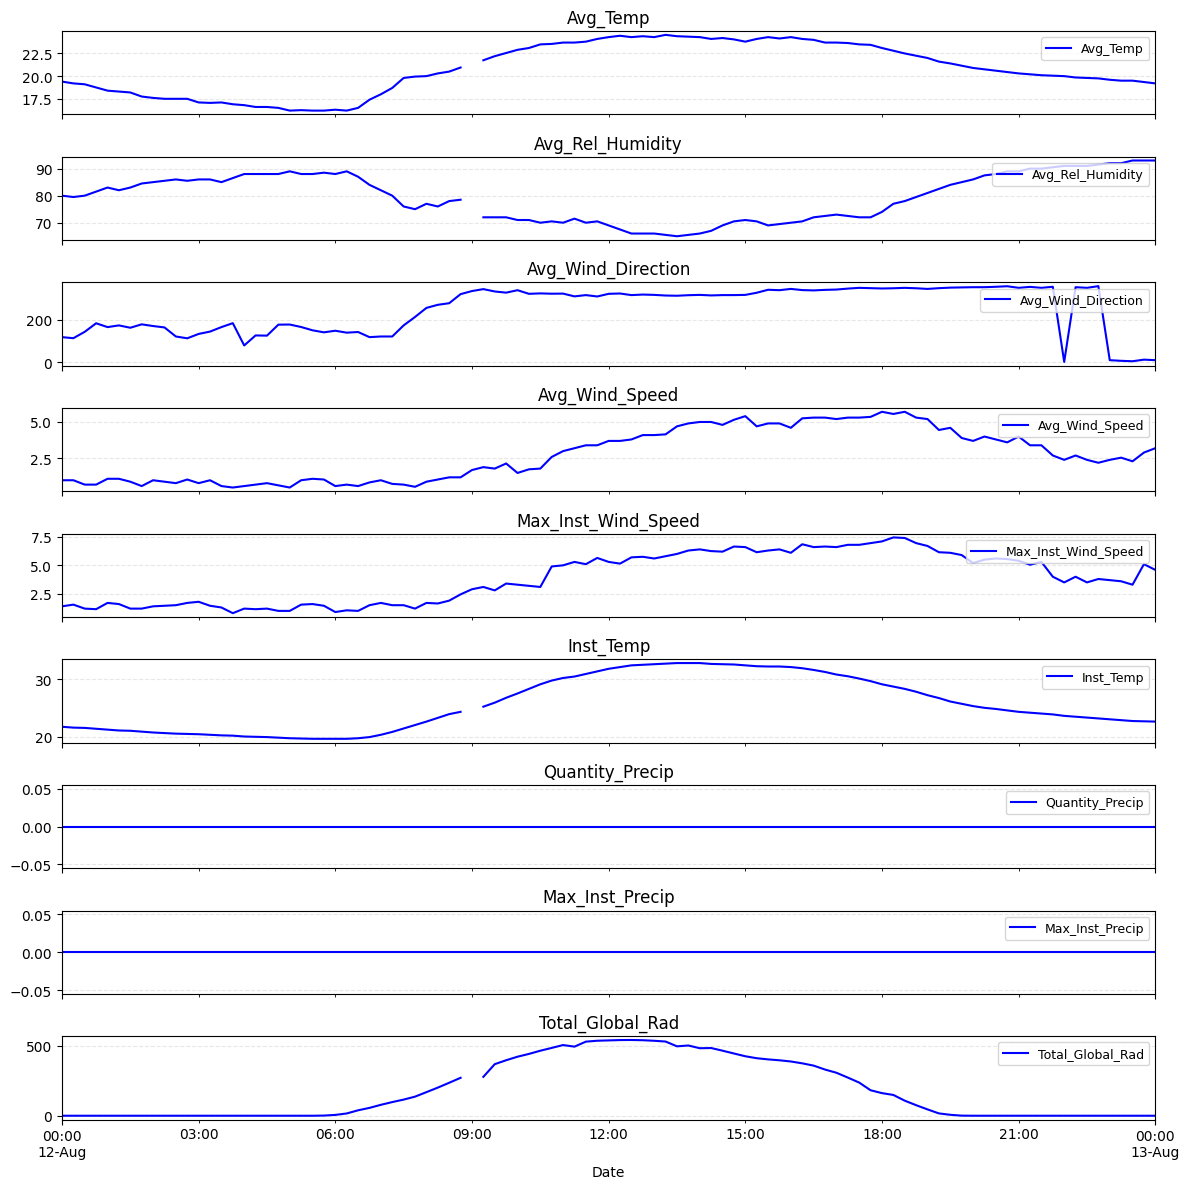

In [52]:
time_mask = (weather_df.index >= np.datetime64("2022-08-12 00:00:00")) & (weather_df.index <= np.datetime64("2022-08-13 00:00:00"))
wc = weather_df.columns

fig, axes = plt.subplots(len(wc), 1, figsize=(12, 12), sharex=True)

for i, name in enumerate(wc):
    ax = axes[i]
    series = weather_df[time_mask][name]

    series.plot(ax=ax, color='blue', legend=True, label=name)

    ax.set_title(name)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()

Let's see the correlation between Meters and weather statistics. A lot can be deduced just from that, it adds a whole layer of information !

1) Like for meters 18 and 25 we see a very strong positive correlation between energy consumption and tempreture!

10) For many others meters the correlation between energy and temreture is negative, which make sense if the building uses electric heating.

2) Some buildings have positive correlation with tempreture. Thsi might be due to the fact that tepreture generally rises during summer time, and the facility migt just be more active during thsi period.

3) Some buildings have correlation (both positive and negative) with radiation level. Negative correlation might be due use of artificial lighting during the night and darker weather overall if it's a houshold. The positive correlation might be due to light hours being the working hours so hence the higher energy consumption (like a shop). The meter 62 seems to have an especially strong negative correlation with radiation + positive correlation with himidity, due to correlation between humidity and radiation.

Overall the Meter-Weather correlation seems like a great clusterisation feature for later on! Also weather information will really help in training a forecasting model. Temreture and radiation data seem to have the most predictive power.


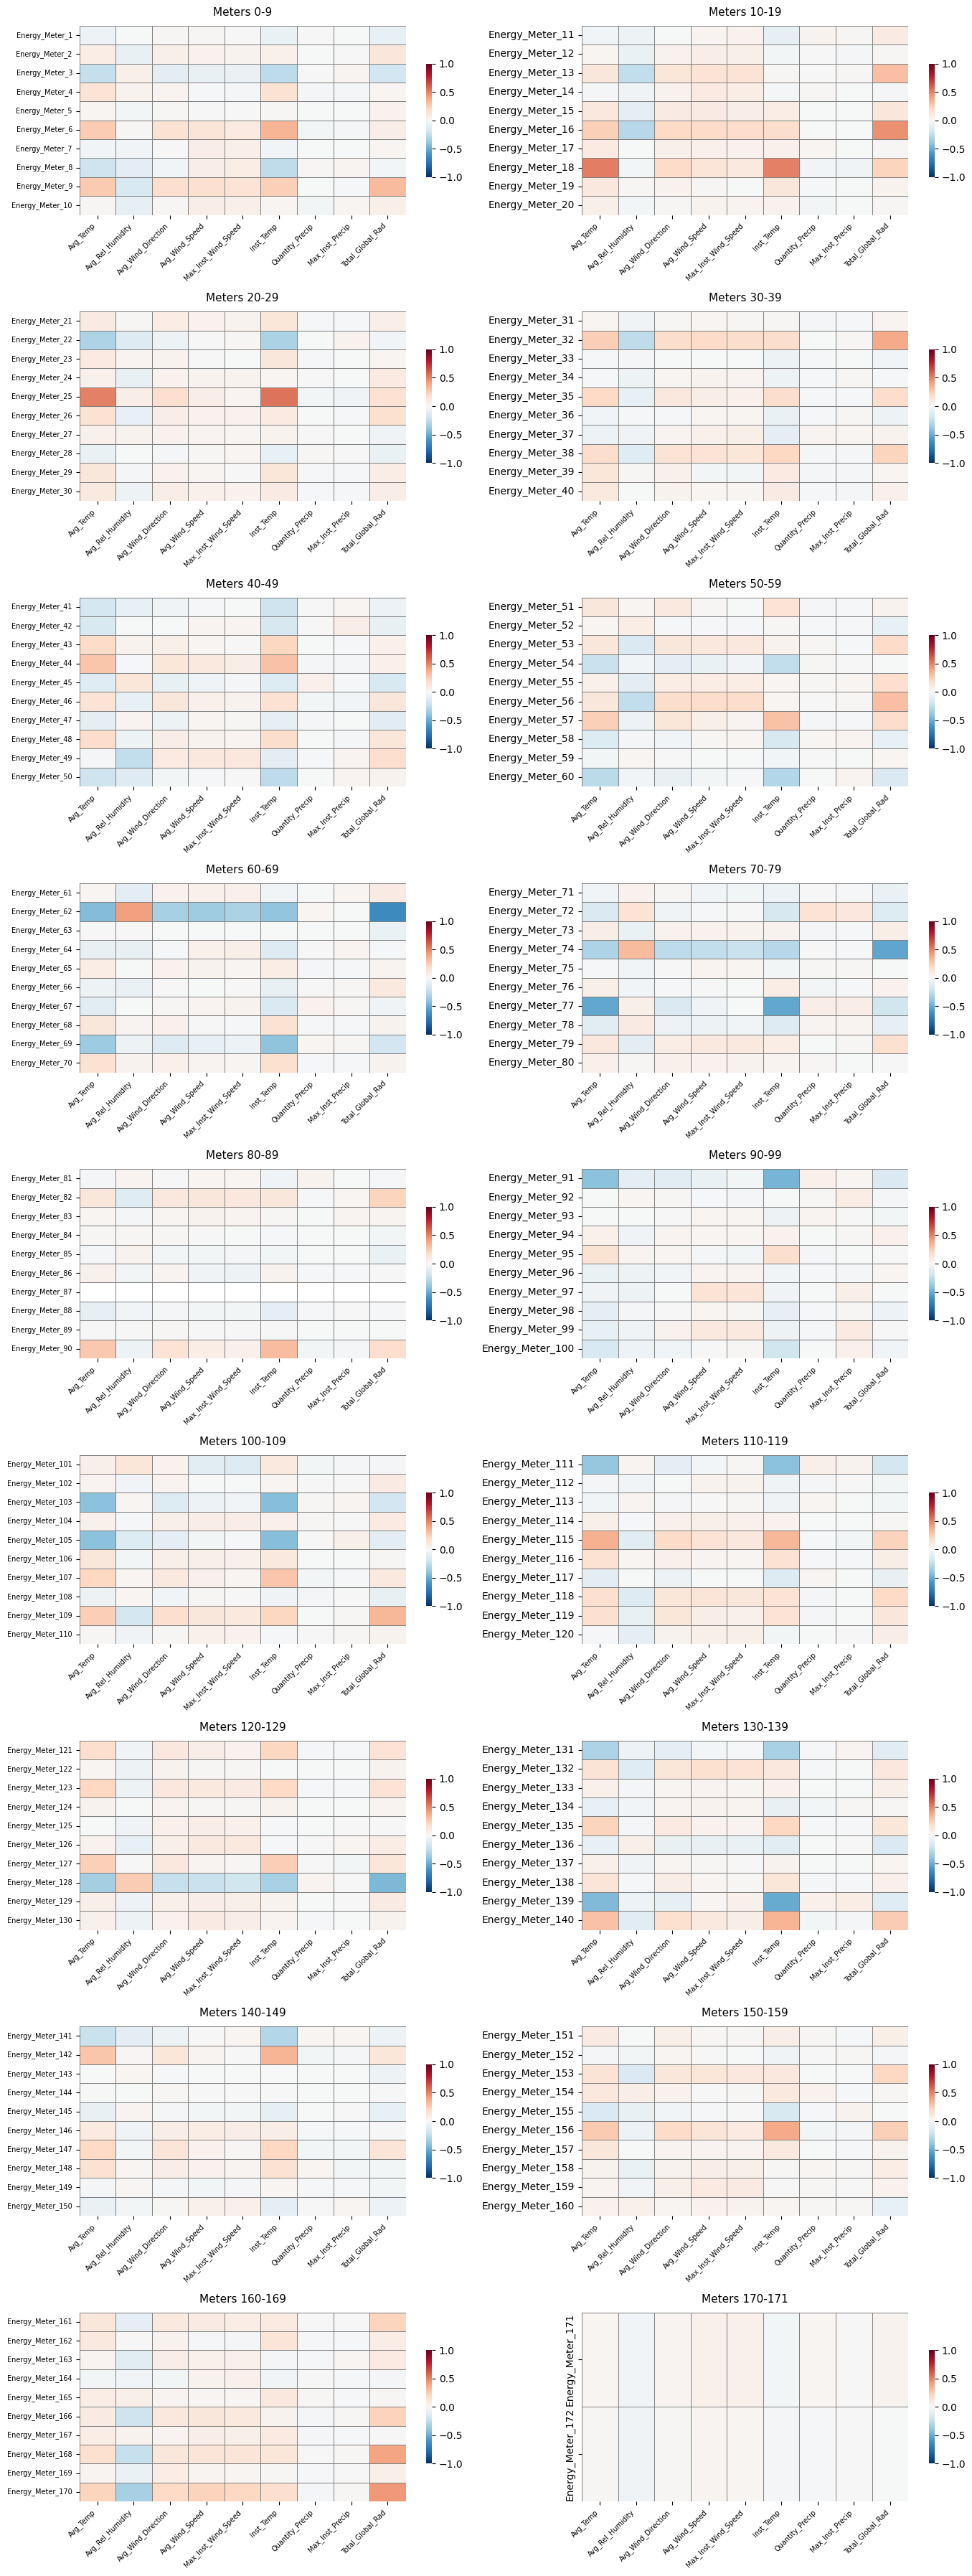

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_combined = energy_df.set_index("Time").merge(weather_df, on="Time")
corr_matrix = df_combined.corr()

corr_subset = corr_matrix.iloc[:172, 172:]

chunk_size = 10
n_meters = corr_subset.shape[0]
row_ranges = [(i, min(i + chunk_size, n_meters)) for i in range(0, n_meters, chunk_size)]

n_chunks = len(row_ranges)
n_cols = 2
n_rows = (n_chunks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, (start, end) in enumerate(row_ranges):
    ax = axes[idx]

    corr_chunk = corr_subset.iloc[start:end, :]

    sns.heatmap(
        corr_chunk,
        ax=ax,
        cmap='RdBu_r',
        center=0,
        vmin=-1,
        vmax=1,
        cbar=True,
        cbar_kws={'shrink': 0.6},
        linewidths=0.5,
        linecolor='gray'
    )

    ax.set_title(f'Meters {start}-{end-1}', fontsize=11, pad=10)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)

    if idx % n_cols == 0:
        plt.setp(ax.get_yticklabels(), fontsize=7)
    else:
        ax.set_ylabel('')

for idx in range(n_chunks, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

Let's take a look at the Meter 18 and 25 and see if there is a overall rise in energy consumption during winter times or is it still correlated on day by day basis. We see that as tempreture goes up, consumption also increases slightly, but also for Meter 25, when tempreture drops too low, consumption also spikes. But also, for Meter 18, we can see that the tempreture is relatively high the first half of the period, then it drops and climble again and only then energy consumption goes up.

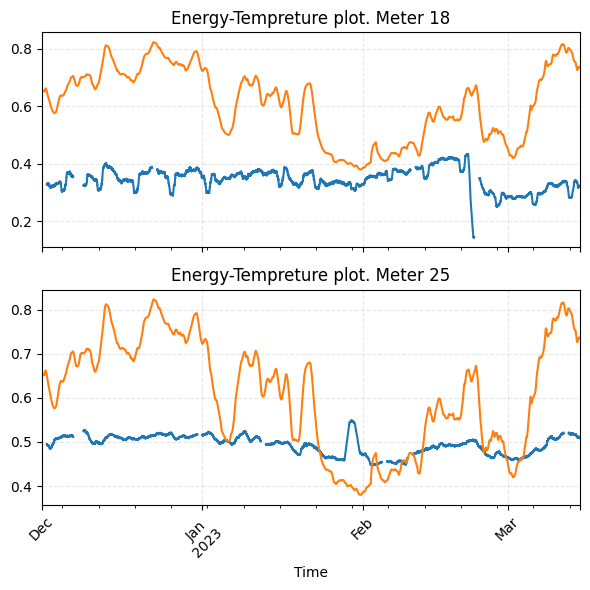

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

energy_df[(energy_df["Time"] >= np.datetime64("2022-12-01 00:00:00")) & (energy_df["Time"] <= np.datetime64("2023-03-15 00:00:00"))].set_index("Time")["Energy_Meter_18"].rolling(96).mean().plot(rot=45, ax=ax[0])
(weather_df['Inst_Temp'].rolling(96).mean()[(weather_df.index >= np.datetime64("2022-12-01 00:00:00")) & (weather_df.index <= np.datetime64("2023-03-15 00:00:00"))]/20).plot(rot=45, ax=ax[0])

ax[0].set_title(f"Energy-Tempreture plot. Meter 18")
ax[0].grid(True, alpha=0.3, linestyle='--')

energy_df[(energy_df["Time"] >= np.datetime64("2022-12-01 00:00:00")) & (energy_df["Time"] <= np.datetime64("2023-03-15 00:00:00"))].set_index("Time")["Energy_Meter_25"].rolling(96).mean().plot(rot=45, ax=ax[1])
(weather_df['Inst_Temp'].rolling(96).mean()[(weather_df.index >= np.datetime64("2022-12-01 00:00:00")) & (weather_df.index <= np.datetime64("2023-03-15 00:00:00"))]/20).plot(rot=45, ax=ax[1])

ax[1].set_title(f"Energy-Tempreture plot. Meter 25")
ax[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

#Initial Assessment of Missing Values

Now we quikly study the extend of NaN vals problem, see if there are some patterns, bad periods or broken meters

In [9]:
#the portion missing values per meter
missing_vals_per_column = energy_df.isna().sum().sort_values(ascending=False) / len(energy_df)
missing_vals_per_column

,0
Energy_Meter_38,0.927802
Energy_Meter_46,0.860990
Energy_Meter_7,0.786775
Energy_Meter_93,0.748884
Energy_Meter_97,0.734359
...,...
Energy_Meter_17,0.102364
Energy_Meter_132,0.102321
Energy_Meter_91,0.102300
Energy_Meter_140,0.100154


In [10]:
print(f"1) at least (excluding time column) {missing_vals_per_column[:-1].min()*100:.2f}% is missing, the highest missing rate is {missing_vals_per_column[:-1].max()*100:.2f}%")
print(f"2) overall {missing_vals_per_column.sum()*len(energy_df):.0f} out of {energy_df.shape[0]*energy_df.shape[1]} is missing")
print(f"3) if we exxlude rows with missing data, then we are left with len(energy_df.dropna()) = {len(energy_df.dropna())} enties left!")

1) at least (excluding time column) 10.02% is missing, the highest missing rate is 92.78%
2) overall 2014280 out of 8063184 is missing
3) if we exxlude rows with missing data, then we are left with len(energy_df.dropna()) = 0 enties left!


Here is a code snipet that hopefuly gives a good feeling of missing values distribution. The resulting plot is supposed to be read as following:

1) on the x-axis we track Energy_Meter's number
2) light colored values correspond to missing measurements, saturated colors - to present ones.
3) red line signifies cutoff threshold, if some meter has missing values for more instances than the threshold then it is colored gray

This plot can help us later to decide what meters we get discard off to make our dataset more suitable for training

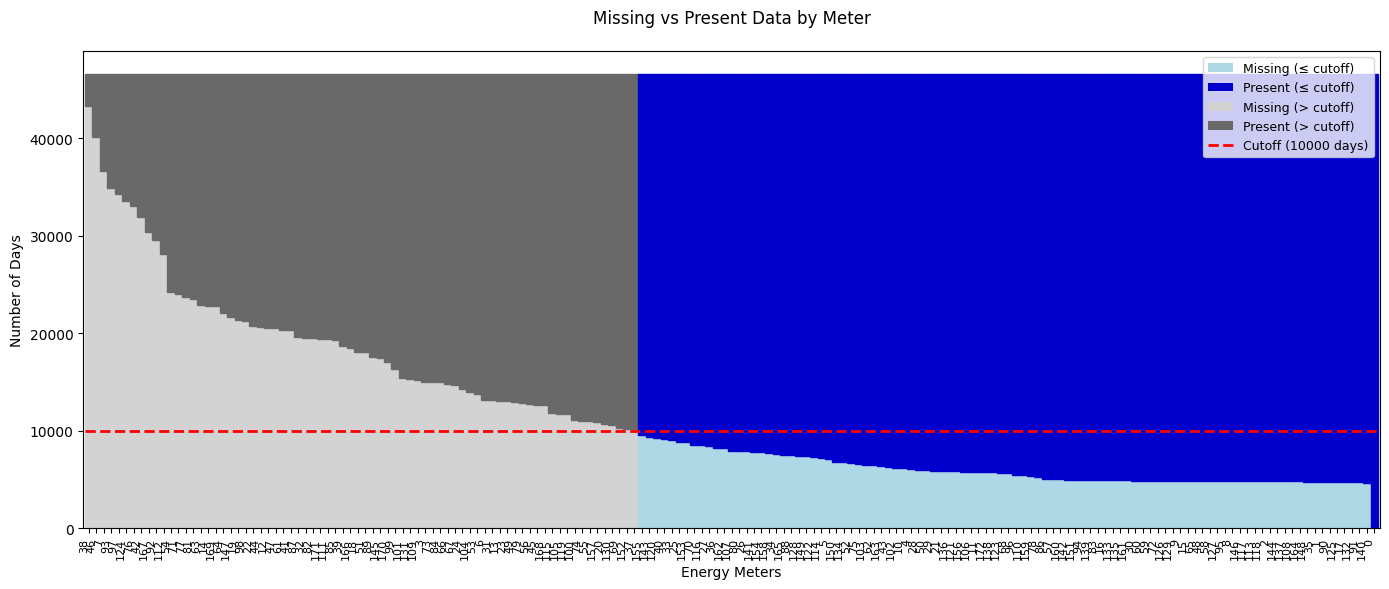

In [62]:
import matplotlib.pyplot as plt
import numpy as np

missing = energy_df.isna().sum().reset_index()
missing.columns = ["columns", "num_missing"]
missing["num_present"] = len(energy_df) - missing['num_missing']
missing = missing.sort_values(by="num_missing", ascending=False)

portion = 0.5
cutoff = len(energy_df)*(1-portion)
cutoff = 10000
mask = missing['num_missing'] <= cutoff

fig, ax = plt.subplots(figsize=(14, 6))

missing.plot(kind="bar", stacked=True, ax=ax, figsize=(14, 6), width=1, legend=False)

color_present_main = '#ADD8E6'  # light blue
color_missing_main = '#0000CD'  # blue
color_present_cutoff = '#D3D3D3'  # light gray
color_missing_cutoff = '#696969'   # dark gray

for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        if mask.iloc[j]:
            bar.set_color(color_present_main if i == 0 else color_missing_main)
        else:
            bar.set_color(color_present_cutoff if i == 0 else color_missing_cutoff)

plt.hlines(y=cutoff, xmin=-0.5, xmax=len(missing)-0.5,
           color="red", linestyle='--', linewidth=2, label=f'Cutoff: {cutoff}')

plt.xticks(rotation=90, ha='right', fontsize=8)
plt.xlabel("Energy Meters", fontsize=10)
plt.ylabel("Number of Days", fontsize=10)
plt.title("Missing vs Present Data by Meter", fontsize=12, pad=20)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_present_main, edgecolor='none', label='Missing (≤ cutoff)'),
    Patch(facecolor=color_missing_main, edgecolor='none', label='Present (≤ cutoff)'),
    Patch(facecolor=color_present_cutoff, edgecolor='none', label='Missing (> cutoff)'),
    Patch(facecolor=color_missing_cutoff, edgecolor='none', label='Present (> cutoff)'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label=f'Cutoff ({cutoff} days)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

Lets visualize the numaber of non working meters by time. Similar to what we've seen on energy consumption plot above, here we observe unstable behavior to the end of measurements period! We will get rid of these measurements to not hurt our model's performance. We also plot for multiple values of the cutoff variable, that is after we throw away "bad" meters. It can inform us on how the NaN distribution changes as we adjust teh threshold.

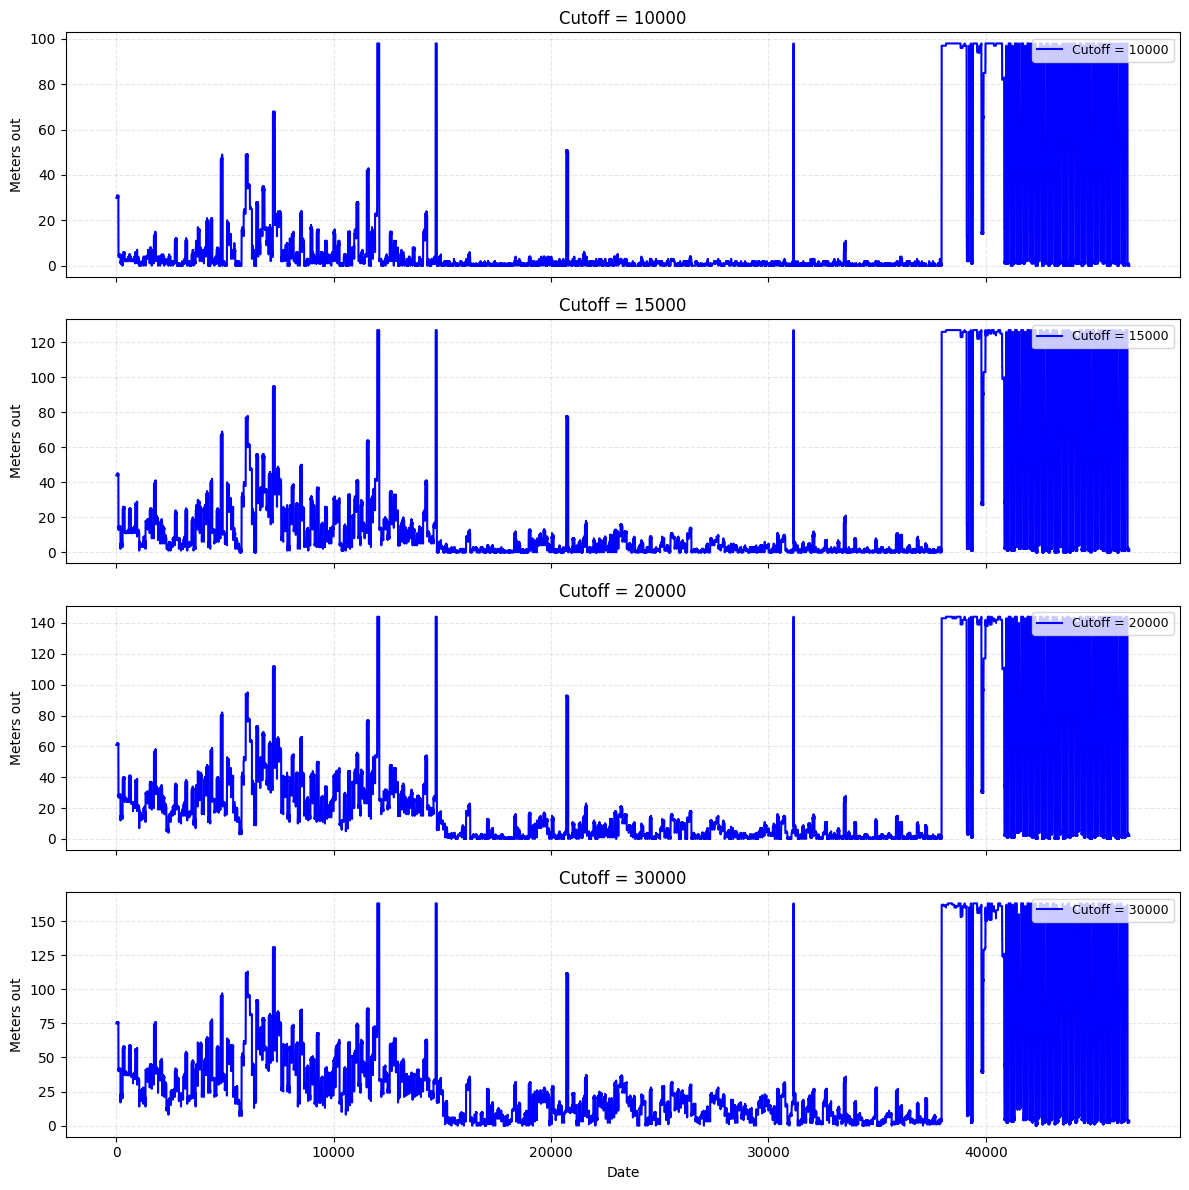

In [12]:
cutoffs = [
            10000,
            15000,
            20000,
            30000,
          ]

fig, axes = plt.subplots(len(cutoffs), 1, figsize=(12, 12), sharex=True)

for i, cutoff in enumerate(cutoffs):
    ax = axes[i]

    missing = energy_df.isna().sum().reset_index()
    missing.columns = ["columns", "num_missing"]
    missing["num_present"] = len(energy_df) - missing['num_missing']

    mask = missing['num_missing'] <= cutoff

    energy_df[missing["columns"][mask].to_list()].isna().sum(axis=1).plot(ax=ax, color='blue', legend=True, label=f"Cutoff = {cutoff}")

    ax.set_title(f"Cutoff = {cutoff}")
    ax.set_ylabel("Meters out")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()

Now we can take a look at energy plots.

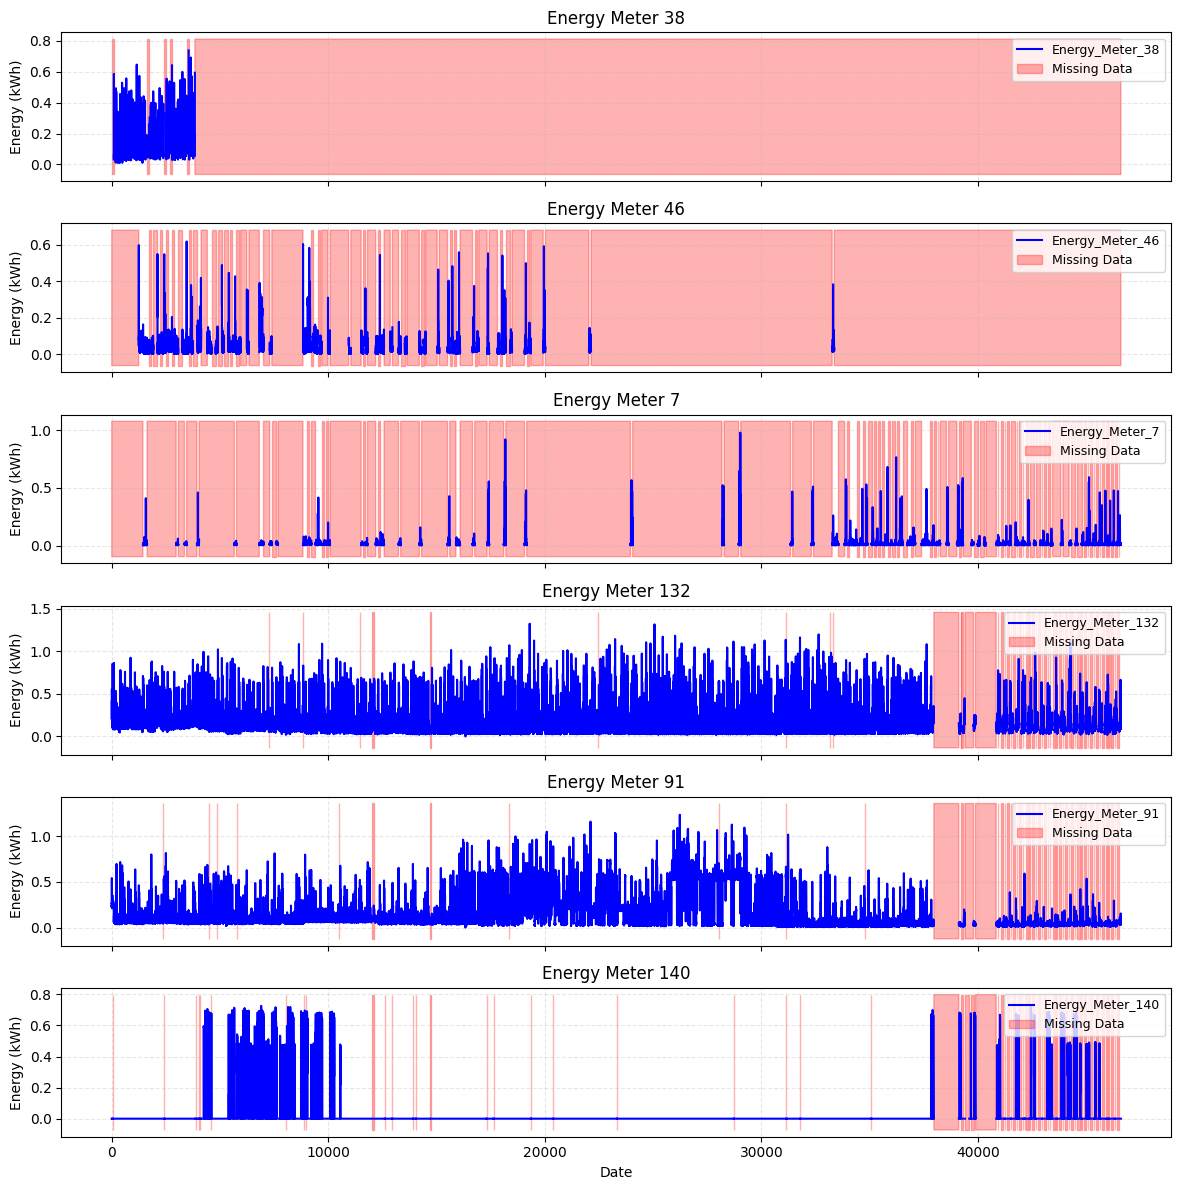

In [17]:
fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

meters = [
    "Energy_Meter_38",
    "Energy_Meter_46",
    "Energy_Meter_7",
    "Energy_Meter_132",
    "Energy_Meter_91",
    "Energy_Meter_140"
]

for i, meter_name in enumerate(meters):
    ax = axes[i]
    series = energy_df[meter_name]

    series.plot(ax=ax, color='blue', legend=True, label=meter_name)

    missing_mask = series.isna()
    if missing_mask.any():
        valid_vals = series.dropna()
        if len(valid_vals) > 0:
            y_min, y_max = valid_vals.min(), valid_vals.max()
            padding = (y_max - y_min) * 0.1 if y_max > y_min else abs(y_max) * 0.1
            y_min -= padding
            y_max += padding
        else:
            y_min, y_max = 0, 1

        ax.fill_between(series.index, y_min, y_max,
                       where=missing_mask,
                       color='red', alpha=0.3,
                       step='pre', label='Missing Data')

    ax.set_title(f"Energy Meter {meter_name.split('_')[-1]}")
    ax.set_ylabel("Energy (kWh)")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()

The data looks chaotic with lots of missing values. Energy_Meter_140 looks suspicious, though it might still be real data. We might need to reconsider including in in our dataset as it is for sure an outlier.

The first 3 plots correspond to those with the biggest number of missing data, and we see indeed the plots look "broken", maybe due to some meters installation issues. For the last 3 we see all of them go off at similar points in time especially at the end of measurements period, which might be due to some external factors such as weather emergencies, blackouts etc. We'll come back to it when we see out weather dataset.

#Energy Meters Cross Correlation Study

Here we study if there are correlations between different meters. It might get useful when we concider measuremenst from multiple meters as features for a model

In [67]:
#later it will be more convinient to have time as an index (for ploting)
energy_df = energy_df.set_index("Time")

We scale the data to make it easier to campare different meter's on the same plot

In [66]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [68]:
energy_df = pd.DataFrame(scale.fit_transform(energy_df), columns = energy_df.columns, index = energy_df.index)

In [69]:
corr = energy_df.corr().to_numpy()
#set lower triangular elements to nan so that we don't have duplicates when we run troygh the matrix
corr[np.tril_indices(172)] = np.nan
corr[(corr >= -0.5) & (corr <= 0.5)] = np.nan
corr_df = pd.DataFrame(corr, columns = energy_df.columns, index = energy_df.columns)

Now we run through the matrix and list the strongest correlations

In [70]:
for i in range(172):
    for j in range(172):
        x = corr_df.iloc[i, j]
        if not np.isnan(x):
            print(corr_df.columns[i], " corr ", corr_df.columns[j], " = ", x)

Energy_Meter_13  corr  Energy_Meter_16  =  0.5198573813342043
Energy_Meter_16  corr  Energy_Meter_32  =  0.5895722708467724
Energy_Meter_16  corr  Energy_Meter_56  =  0.5089606314442391
Energy_Meter_16  corr  Energy_Meter_62  =  -0.5869369063441434
Energy_Meter_16  corr  Energy_Meter_74  =  -0.5203511008044573
Energy_Meter_16  corr  Energy_Meter_170  =  0.551048936295006
Energy_Meter_32  corr  Energy_Meter_49  =  0.6398352760639219
Energy_Meter_32  corr  Energy_Meter_56  =  0.6232417416634732
Energy_Meter_32  corr  Energy_Meter_170  =  0.5841912101810559
Energy_Meter_49  corr  Energy_Meter_56  =  0.6574558177598929
Energy_Meter_49  corr  Energy_Meter_170  =  0.5702835764927483
Energy_Meter_56  corr  Energy_Meter_170  =  0.571101960215945
Energy_Meter_62  corr  Energy_Meter_74  =  0.8366684465322946
Energy_Meter_62  corr  Energy_Meter_128  =  0.6353831199427826
Energy_Meter_62  corr  Energy_Meter_168  =  -0.5369415090487993
Energy_Meter_74  corr  Energy_Meter_128  =  0.5415537217782252


Let's visually compare the correlated meters! Also, we see that correlated meters form groups, some are correlated to many others. It hints to us that some effective clustering is possible

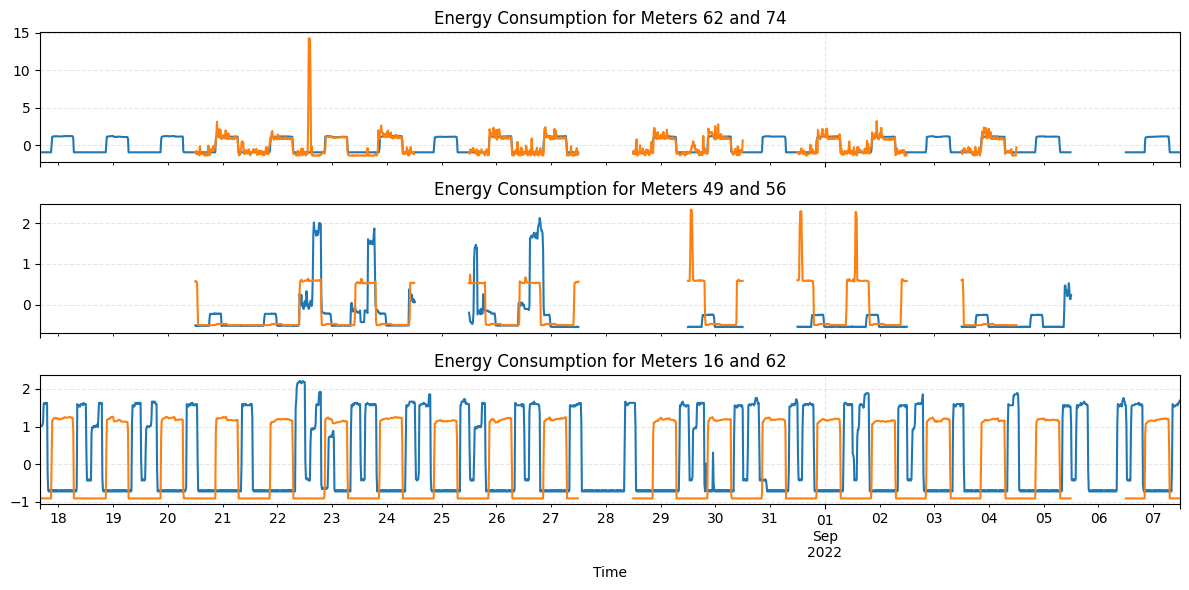

In [71]:

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

energy_df["Energy_Meter_62"][10000:12000].plot(ax=ax[0])
energy_df["Energy_Meter_74"][10000:12000].plot(ax=ax[0])
ax[0].set_title(f"Energy Consumption for Meters 62 and 74")
ax[0].grid(True, alpha=0.3, linestyle='--')

energy_df["Energy_Meter_49"][10000:12000].plot(ax=ax[1])
energy_df["Energy_Meter_56"][10000:12000].plot(ax=ax[1])
ax[1].set_title(f"Energy Consumption for Meters 49 and 56")
ax[1].grid(True, alpha=0.3, linestyle='--')

energy_df["Energy_Meter_16"][10000:12000].plot(ax=ax[2])
energy_df["Energy_Meter_62"][10000:12000].plot(ax=ax[2])
ax[2].set_title(f"Energy Consumption for Meters 16 and 62")
ax[2].grid(True, alpha=0.3, linestyle='--')


plt.tight_layout()
plt.show()

#Montly Patterns Study

In [10]:
energy_df["month"] = energy_df.index.month_name()
energy_df["day"] = energy_df.index.day_name()
energy_df.head()

,Energy_Meter_1,Energy_Meter_2,Energy_Meter_3,Energy_Meter_4,Energy_Meter_5,Energy_Meter_6,Energy_Meter_7,Energy_Meter_8,Energy_Meter_9,Energy_Meter_10,...,Energy_Meter_165,Energy_Meter_166,Energy_Meter_167,Energy_Meter_168,Energy_Meter_169,Energy_Meter_170,Energy_Meter_171,Energy_Meter_172,month,day
Time,,,,,,,,,,,,,,,,,,,,,
2022-05-05 12:00:00,-0.234968,NaN,-0.572023,-0.077290,-0.201075,NaN,NaN,NaN,NaN,-0.334447,...,-0.261512,NaN,NaN,NaN,1.902315,NaN,NaN,-0.559324,May,Thursday
2022-05-05 12:15:00,-0.215898,NaN,-0.502566,0.157913,0.207132,NaN,NaN,NaN,NaN,0.528066,...,-0.261512,NaN,NaN,NaN,1.269976,NaN,NaN,-0.217065,May,Thursday
2022-05-05 12:30:00,0.279906,NaN,-0.551186,-0.008689,-0.201075,NaN,NaN,NaN,NaN,-0.484450,...,-0.261512,NaN,NaN,NaN,0.853753,NaN,NaN,-0.381064,May,Thursday
2022-05-05 12:45:00,0.375253,NaN,-0.703992,-0.067490,-0.201075,NaN,NaN,NaN,NaN,0.228062,...,-0.261512,NaN,NaN,NaN,-0.146783,NaN,NaN,-0.174282,May,Thursday
2022-05-05 13:00:00,0.308510,NaN,-0.703992,-0.057690,1.976031,NaN,NaN,NaN,NaN,0.003058,...,-0.261512,NaN,NaN,NaN,-0.154787,NaN,NaN,-0.445237,May,Thursday


In [29]:
melted_df = energy_df[energy_df.columns[:-1]].melt(id_vars = "month")
melted_df.rename(columns={"value" : "consumption", "variable" : "meter"}, inplace=True)
# .rename({"value" : "consumption"}).groupby("month").mean()

In [37]:
#just a useful list of month names in order for when we need to sort months in time

months = [
              "January",
              "February",
              "March",
              "April",
              "May",
              "June",
              "July",
              "August",
              "September",
              "October",
              "November",
              "December"
        ]


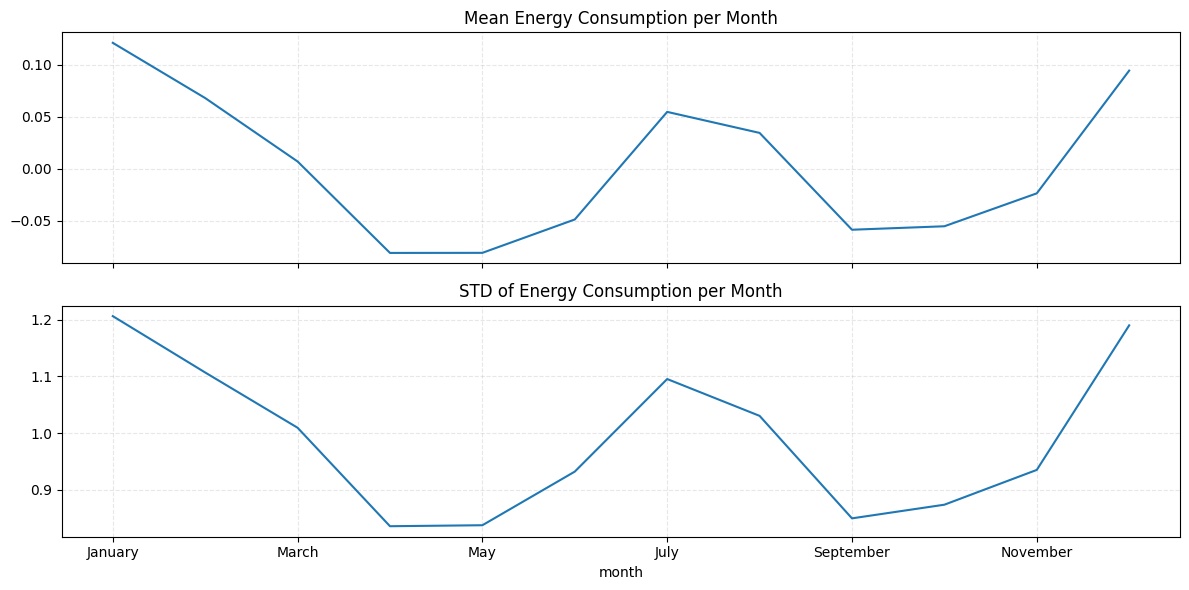

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

mean_per_month = melted_df.groupby("month")["consumption"].mean()
mean_per_month = mean_per_month[months]
mean_per_month.plot(ax=ax[0])
ax[0].set_title(f"Mean Energy Consumption per Month")
ax[0].grid(True, alpha=0.3, linestyle='--')

std_per_month = melted_df.groupby("month")["consumption"].std()
std_per_month = std_per_month[months]
std_per_month.plot(ax=ax[1])
ax[1].set_title(f"STD of Energy Consumption per Month")
ax[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


# Treating NaN Values + STL Decomposition

1) We examine missing values to decide what data to discard off altogether
2) We use spline interpolation + STL predictions to fill in the data that is still missing after the first step
3) We also examine STL data for insight into seasonality

In [7]:
#we will solely rely on this package for implementation of classic STL
from statsmodels.tsa.seasonal import STL

In [8]:
#create a dataframe with intacked raw data for more robust precessing
energy_raw_df = pd.read_csv(energy_file_name).set_index("Time")
energy_raw_df.index = pd.to_datetime(energy_raw_df.index)
energy_raw_df.head(3)

,Energy_Meter_1,Energy_Meter_2,Energy_Meter_3,Energy_Meter_4,Energy_Meter_5,Energy_Meter_6,Energy_Meter_7,Energy_Meter_8,Energy_Meter_9,Energy_Meter_10,...,Energy_Meter_163,Energy_Meter_164,Energy_Meter_165,Energy_Meter_166,Energy_Meter_167,Energy_Meter_168,Energy_Meter_169,Energy_Meter_170,Energy_Meter_171,Energy_Meter_172
Time,,,,,,,,,,,,,,,,,,,,,
2022-05-05 12:00:00,0.068,NaN,0.034,0.038,0.000,NaN,NaN,NaN,NaN,0.007,...,NaN,0.004,0.0,NaN,NaN,NaN,0.395,NaN,NaN,0.008
2022-05-05 12:15:00,0.070,NaN,0.044,0.062,0.006,NaN,NaN,NaN,NaN,0.030,...,NaN,0.003,0.0,NaN,NaN,NaN,0.316,NaN,NaN,0.056
2022-05-05 12:30:00,0.122,NaN,0.037,0.045,0.000,NaN,NaN,NaN,NaN,0.003,...,NaN,0.004,0.0,NaN,NaN,NaN,0.264,NaN,NaN,0.033


Let's once again visualize the plot for one of the meters with missing values marked. We see that, as we saw earlier, that most of the NaNs are concentrated to the end of measurements period, so we'll throw this data without considering it as it's highly unreliable.

Text(0.5, 0, 'Date')

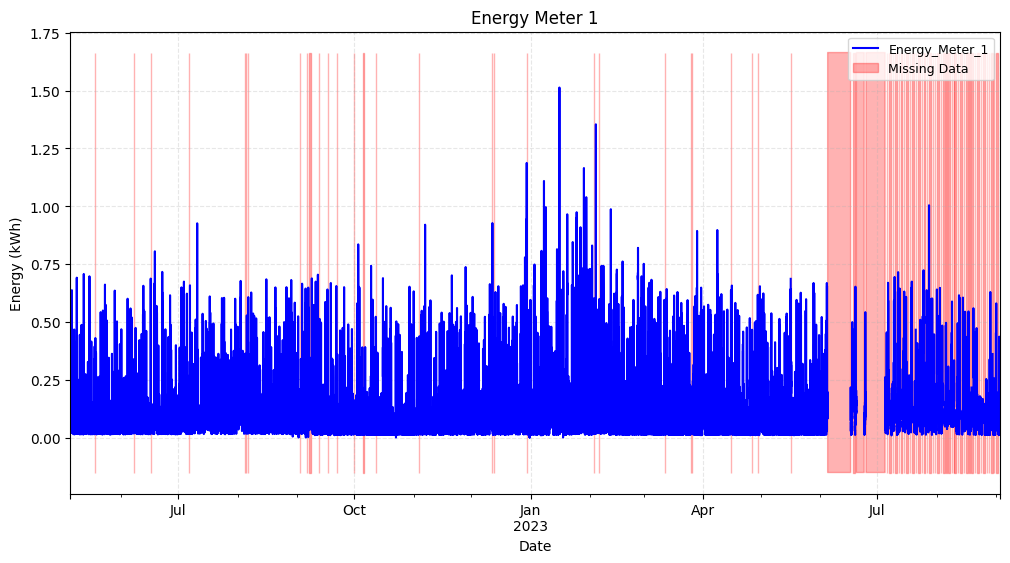

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

meter_name = "Energy_Meter_1"

series = energy_raw_df[meter_name]

series.plot(ax=ax, color='blue', legend=True, label=meter_name)

missing_mask = series.isna()
if missing_mask.any():
    valid_vals = series.dropna()
    if len(valid_vals) > 0:
        y_min, y_max = valid_vals.min(), valid_vals.max()
        padding = (y_max - y_min) * 0.1 if y_max > y_min else abs(y_max) * 0.1
        y_min -= padding
        y_max += padding
    else:
        y_min, y_max = 0, 1

    ax.fill_between(series.index, y_min, y_max,
                    where=missing_mask,
                    color='red', alpha=0.3,
                    step='pre', label='Missing Data')

ax.set_title(f"Energy Meter {meter_name.split('_')[-1]}")
ax.set_ylabel("Energy (kWh)")
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=9)

ax.set_xlabel("Date")

Now we create a mask of non missing values before we interpolate them, for later use with STL decomposition. So here we
1) discard off data after Jun 2023
2) compute the present values mask
3) interpolate the missing values with spline method (more robust then polynomial, naturally interpolated constantly for big gaps). Interpolation is needed before feeding the data into STL algorithm. Even though the original implementation is functionabel even with NaN values, statsmodels implementation might not work properly.
4) interpolated missing values are then replaced with STL predictions that capture the data structure much better, especially for big gaps

In [27]:
meter_name = 'Energy_Meter_1'
cut_off_date = np.datetime64("2023-06-01")
cut_off_mask = energy_raw_df.index <= np.datetime64("2023-06-01")

meter_df = energy_raw_df[cut_off_mask][[meter_name, "isnan_mask"]]
meter_df["isnan_mask"] = 1-meter_df[meter_name].isna()
meter_df[meter_name] = meter_df[meter_name].interpolate(method = "spline", order=2)
meter_df["Masked_Meter"] = meter_df[meter_name] * meter_df["isnan_mask"]


For the sake a visual comfort we only look at on meter measurements that span 2 weeks. The same processing can be applied to the full series, without change. Here I purposfuly choose September data as it has a big gap of missing values spaning a whole day. I want to check how well STL can deal with it!

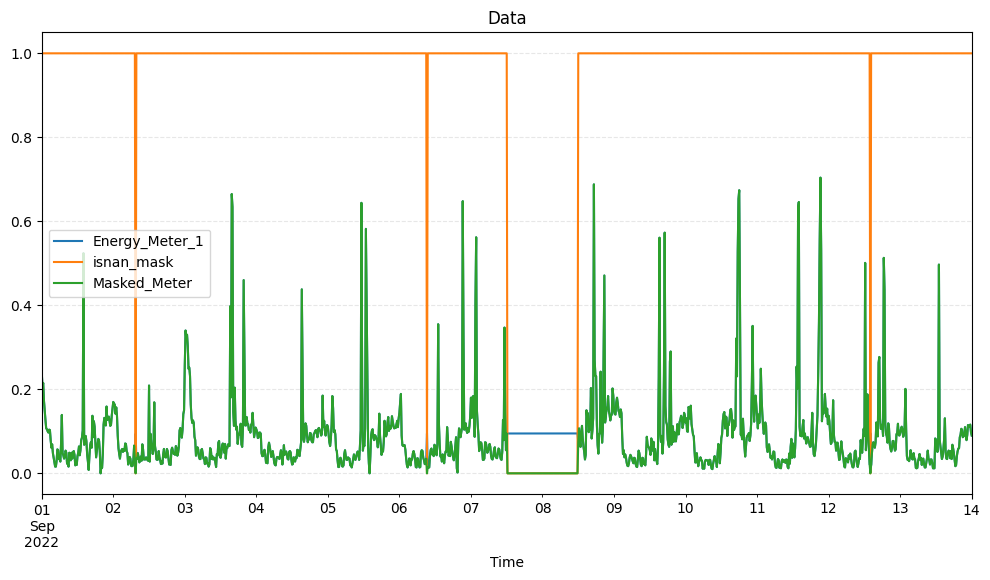

In [29]:
start_date = np.datetime64("2022-09-01")
end_date =  np.datetime64("2022-09-14")
time_mask = (meter_df.index >= start_date) & (meter_df.index <= end_date)

data_df = meter_df.dropna()[time_mask]["Masked_Meter"]

fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

meter_df[time_mask].plot(ax=ax)
ax.set_title(f"Data")
ax.grid(True, alpha=0.3, linestyle='--')


Now the main part. We apply STL decomposition. I consider STL as it is widely used and is highly flexible. 3 key parameters that we need to set:

1) period - this is the seasonality period that we want to capture. Data is measured with 15 mins intervals, we want to track dayly seasonality now, so take period = 60 mins / 15 mins * 24 = 1 hour.

2) seasonal is the parameter that regulates the amount of smoothing applied to the seasonal component. Empirically, higher value results in smoother curve that captures less local structure. Too small of a value results in overfitting to noise. I choose seasonal = 9, as a sweetspot (recomended at least value >= 7)

3) robust = True meaning that STL will use iterative robustness estimates to not overfitt to outliers

In [30]:
stl = STL(data_df, period = 60//15*24, seasonal=9, robust=True)
result = stl.fit()


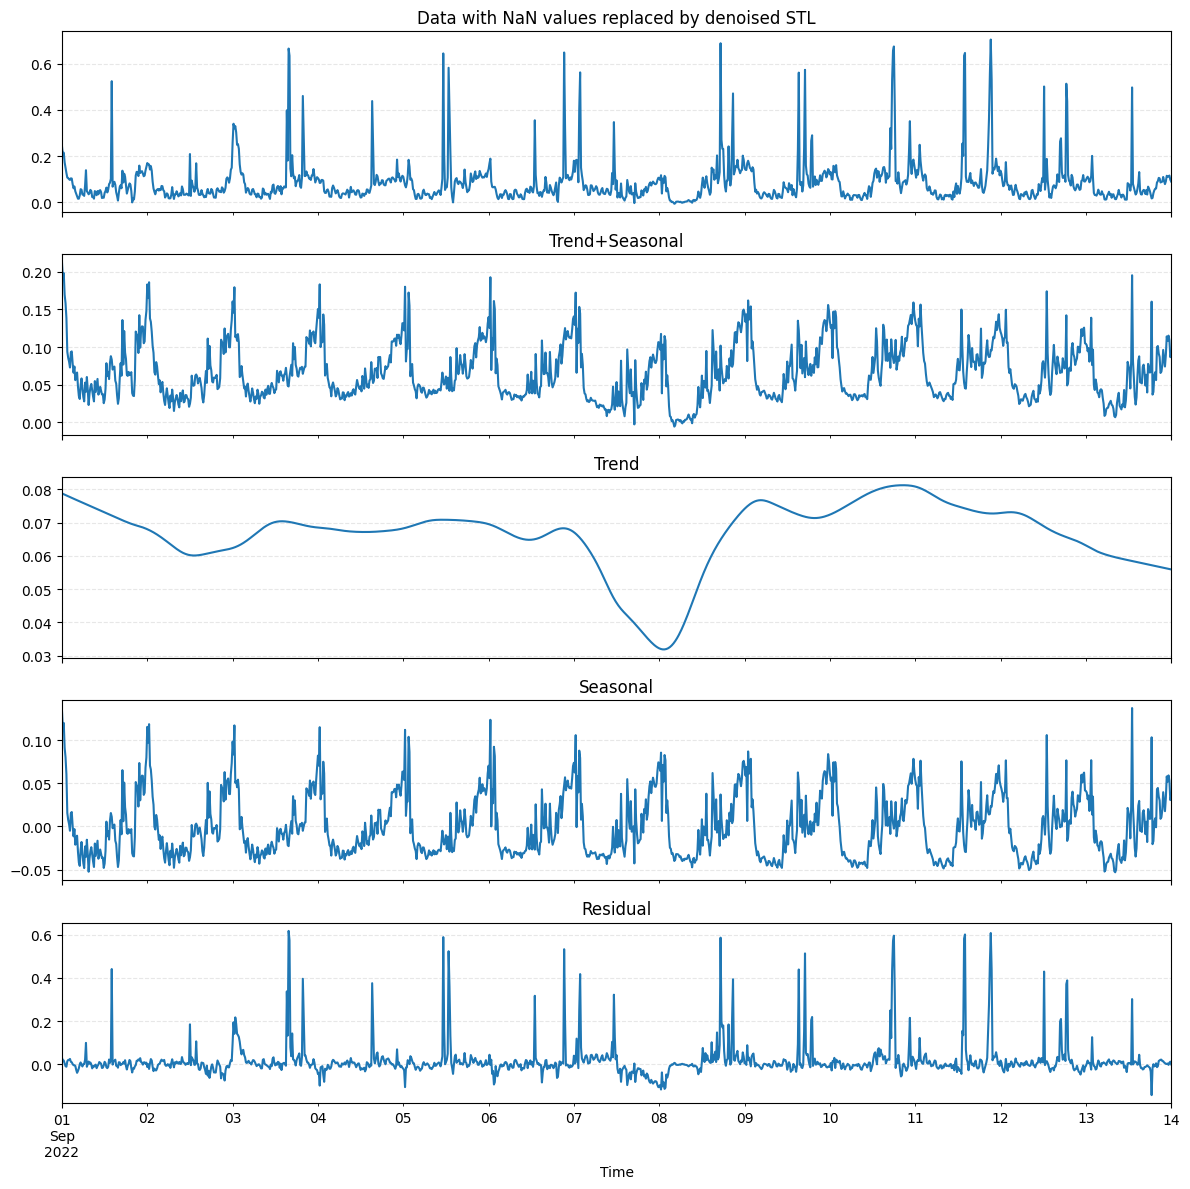

In [31]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

(result.trend + result.seasonal + meter_df[time_mask]["isnan_mask"]*result.resid).plot(ax=ax[0])
ax[0].set_title(f"Data with NaN values replaced by denoised STL")
ax[0].grid(True, alpha=0.3, linestyle='--')

(result.trend + result.seasonal).plot(ax=ax[1])
ax[1].set_title(f"Trend+Seasonal")
ax[1].grid(True, alpha=0.3, linestyle='--')

result.trend.plot(ax=ax[2])
ax[2].set_title(f"Trend")
ax[2].grid(True, alpha=0.3, linestyle='--')

result.seasonal.plot(ax=ax[3])
ax[3].set_title(f"Seasonal")
ax[3].grid(True, alpha=0.3, linestyle='--')

result.resid.plot(ax=ax[4])
ax[4].set_title(f"Residual")
ax[4].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Let's again look at NaN values distribution with catoffs after we discard off post-Jun data. We see that now we have overall bettre quality of data where can save meters after additional controll for minimal required portion of measurements present. For example, we can leave meters with at least 2/3 of vals present by discarding only about 1/5 of all meters.

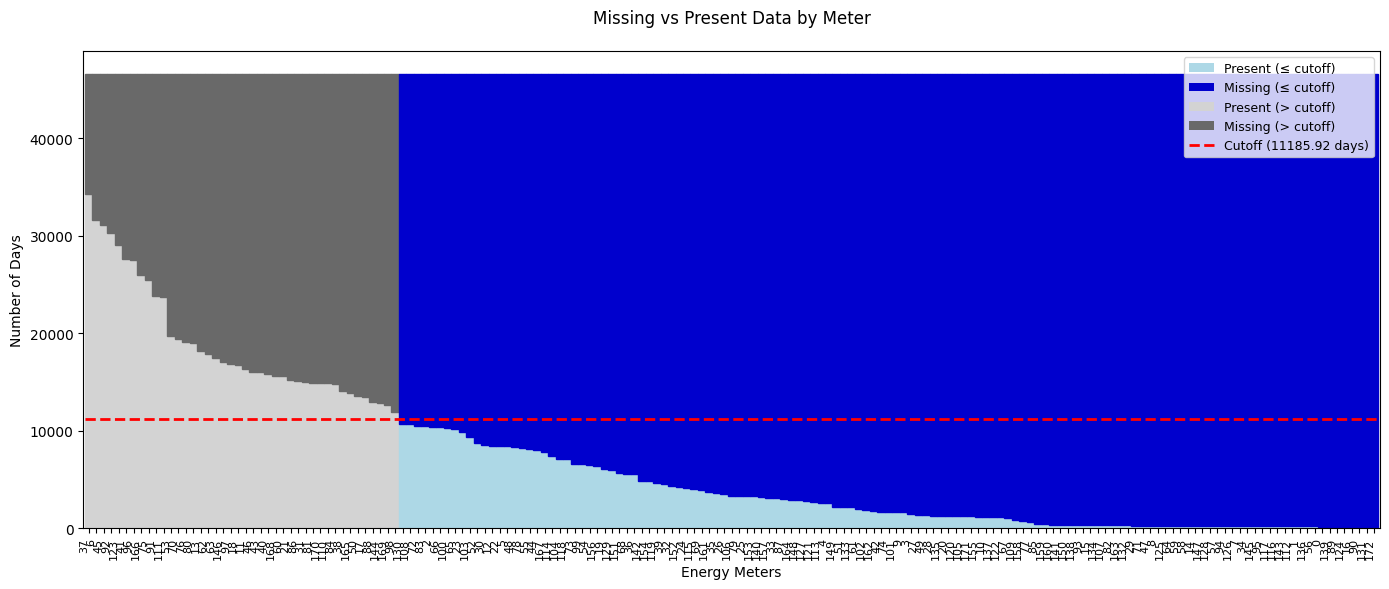

In [61]:
import matplotlib.pyplot as plt
import numpy as np

cut_off_date = np.datetime64("2023-06-01")
cut_off_mask = energy_raw_df.index <= np.datetime64("2023-06-01")

missing = energy_raw_df[cut_off_mask].isna().sum().reset_index()L
missing.columns = ["columns", "num_missing"]
missing["num_present"] = len(energy_df) - missing['num_missing']
missing = missing.sort_values(by="num_missing", ascending=False)

portion = 0.76
cutoff = len(energy_df)*(1-portion)
mask = missing['num_missing'] <= cutoff

fig, ax = plt.subplots(figsize=(14, 6))

missing.plot(kind="bar", stacked=True, ax=ax, figsize=(14, 6), width=1, legend=False)

color_present_main = '#ADD8E6'  # light blue
color_missing_main = '#0000CD'  # blue
color_present_cutoff = '#D3D3D3'  # light gray
color_missing_cutoff = '#696969'   # dark gray

for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        if mask.iloc[j]:
            bar.set_color(color_present_main if i == 0 else color_missing_main)
        else:
            bar.set_color(color_present_cutoff if i == 0 else color_missing_cutoff)

plt.hlines(y=cutoff, xmin=-0.5, xmax=len(missing)-0.5,
           color="red", linestyle='--', linewidth=2, label=f'Cutoff: {cutoff}')

plt.xticks(rotation=90, ha='right', fontsize=8)
plt.xlabel("Energy Meters", fontsize=10)
plt.ylabel("Number of Days", fontsize=10)
plt.title("Missing vs Present Data by Meter", fontsize=12, pad=20)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_present_main, edgecolor='none', label='Present (≤ cutoff)'),
    Patch(facecolor=color_missing_main, edgecolor='none', label='Missing (≤ cutoff)'),
    Patch(facecolor=color_present_cutoff, edgecolor='none', label='Present (> cutoff)'),
    Patch(facecolor=color_missing_cutoff, edgecolor='none', label='Missing (> cutoff)'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label=f'Cutoff ({cutoff} days)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

#Conclusion

This concludes EDA part of working with this dataset. More could be done, but we need to stop somewhere. The result so far:

1) Weather data is predictive of energy consumptiom
2) Weather data if informative of buildings types
3) There is some possible redundancy in the weather data
4) Energy measurements have clear structure
5) Energy meters tend to cluster  based on correlations with one another and weather measurements

There is a lot of missing values in energy_df, so deal with thsi problem, the following steps are suggested:

1) Throw away post-June data, as it is highly unreliable
2) Throw away some meters with the most values missing
3) For the rest of the dataset apply STL to fill in the missing values

Next we follow with:
1) Clusterization. It will further inform us on the structure of our data and suggest some model compartmentization
2) Get the final processed train-test data with cluster labels
3) Train a baseline model, like SARIMA
4) Create features for training. Train XGBoost model. Evaluate.   